# Titanic Prediction, with all models explains

This notebook extracts the features, performs the preprocessing steps, and applies different models. 
Each model is described, highlighting its benefits and potential drawbacks

# 0. Load libraries and input data

In [40]:
import os
import sys
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTENC

# Modelling
# Standard Machine Learning Algorithms
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense
from keras.callbacks import EarlyStopping

sys.path.append("../")
from utils import preprocessing_tools

print("Tensorflow version " + str(tf.__version__))

config = {
    'test_size': 0.2,
    'seed': 14,
    'balance_dataset': True,

    # NN Parameters
    'batch_size': 50,
    "no_epochs": 25
}

train_data = pd.read_csv('../input/train.csv')
train_data.head(5)

Tensorflow version 2.10.0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. Preprocessing steps
This section includes:
- Feature extraction
- Preprocessing using Pipelines, including
    - Fix categorical missing values with rules
    - One-hot encoding
    - Fix missing values with Imputer
    - Feature scaling
    - If required, balance dataset
- Train/Test split

In [29]:
# Extract relevant features
train_data = preprocessing_tools.titanic_feature_extraction(train_data)

# Fill NA from Embarked
train_data['Embarked'] = train_data.Embarked.fillna('NoBoardingRecorded')

# OneHotEncode Categories
cat_encoder = OneHotEncoder()
cat_features = ['Embarked', 'cabinLetter', 'Pclass']
all_df = [train_data]
# Perform OneHotEncoder for each feature
for cat in cat_features:
    cat_x = cat_encoder.fit_transform(train_data[[cat]])
    all_df.append(pd.DataFrame(
        cat_x.toarray(), 
        columns=cat_encoder.categories_, 
        index=train_data.index))

# Concatenate OneHotEncoder results
train_data = pd.concat(all_df, axis=1)

# Input missing values of age as the median
median_imputer = SimpleImputer(strategy='median')
train_data['Age'] = median_imputer.fit_transform(train_data[['Age']])

# Standardise the numerical values
num_scaler = StandardScaler()
num_features = ['Age', 'Fare', 'SibSp', 'Parch']
train_data[num_features] = num_scaler.fit_transform(train_data[num_features])

# Drop columns not used for prediction
clean_train_data = train_data.drop(['PassengerId', 'Name', 'Sex', 'Pclass', 'Ticket', 'Cabin', 'Embarked', 'cabinLetter'], axis=1)
clean_train_data.head()

,Survived,Age,SibSp,Parch,Fare,hasCabin,numCabins,isFemale,"(C,)","(NoBoardingRecorded,)",...,"(C,)","(D,)","(E,)","(F,)","(G,)","(No Cabin,)","(T,)","(1,)","(2,)","(3,)"
0,0,-0.565736,0.432793,-0.473674,-0.502445,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,0.663861,0.432793,-0.473674,0.786845,1,1.0,1,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,-0.258337,-0.474545,-0.473674,-0.488854,0,0.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,0.433312,0.432793,-0.473674,0.420730,1,1.0,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0.433312,-0.474545,-0.473674,-0.486337,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [30]:
# Split dataset between features and labels
y = clean_train_data.Survived
X = clean_train_data.drop(["Survived"], axis=1)
X.head()

,Age,SibSp,Parch,Fare,hasCabin,numCabins,isFemale,"(C,)","(NoBoardingRecorded,)","(Q,)",...,"(C,)","(D,)","(E,)","(F,)","(G,)","(No Cabin,)","(T,)","(1,)","(2,)","(3,)"
0,-0.565736,0.432793,-0.473674,-0.502445,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.663861,0.432793,-0.473674,0.786845,1,1.0,1,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.258337,-0.474545,-0.473674,-0.488854,0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.433312,0.432793,-0.473674,0.420730,1,1.0,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.433312,-0.474545,-0.473674,-0.486337,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [31]:
# If requested, balance the dataset using SMOTEC
if config['balance_dataset']:
    smote_nc = SMOTENC(categorical_features=list(range(7, 23)), random_state=config['seed'])
    X, y = smote_nc.fit_resample(X, y)

/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [32]:
# Perform Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config['test_size'], random_state=14)

# 2. Titanic Modelling 

In this section, I explore the different algorithm, deep-diving on how these algorithms work, the situations in which these algorithms would perform well and its drawbacks.  

In [33]:
# Establish the baseline performance with the Dummy Classifier
DM_model = DummyClassifier(strategy='most_frequent')
Null_model = cross_validate(DM_model, X_train, y_train, cv=5, scoring=["accuracy", "roc_auc", "recall"])
Null_accuracy = sum(Null_model['test_accuracy'])/len(Null_model['test_accuracy'])
Null_recall = sum(Null_model['test_recall'])/len(Null_model['test_recall'])
Null_AUC = sum(Null_model['test_roc_auc'])/len(Null_model['test_roc_auc'])

print(f"Null Accuracy -> {Null_accuracy}")
print(f"Null Recall   -> {Null_recall}")
print(f"Null AUC      -> {Null_AUC}")

Null Accuracy -> 0.504551948051948
Null Recall   -> 1.0
Null AUC      -> 0.5


In [34]:
def run_model_and_evaluate(model, X_train, y_train):
    
    # Instanciate a Cross-Validation model
    cv = StratifiedKFold(n_splits=5)

    # Create empty results
    conf_matrix = np.zeros((2,2))
    accuracy = []
    recall = []
    auc = []

    # For every split    
    for idx_train, idx_test in cv.split(X_train, y_train):
    
        # Obtain the split indeces
        X_cv, y_cv = X_train.values[idx_train], y_train.values[idx_train]

        # Train the models 
        model.fit(X_cv, y_cv)

        # Obtain prediction dataset
        X_cv, y_cv = X_train.values[idx_test], y_train.values[idx_test]

        # Predict both models
        model_pred = model.predict(X_cv)

        # Store Confusion Matrix + Accuracy Score + Recall Score + AUC
        conf_matrix += confusion_matrix(y_cv, model_pred)
        accuracy.append(accuracy_score(y_cv, model_pred))
        recall.append(recall_score(y_cv, model_pred))
        auc.append(roc_auc_score(y_cv, model_pred))

    return conf_matrix, accuracy, recall, auc

## K-Nearest Neighbours

Select the K points closest to the test point, and selects the majority class
- Advantages: 
    - Simple, easy to explain to stakeholders
    - Robust to noisy data
    - Handles well multi-label
    - Only one hyperparameter to tune
    - Can be used for regression and classification
- Drawbacks: 
    - RAM hungry, need to load the entire dataset
    - Computational cost of distance calculation
    - Sensitive to outliers

In [35]:
KNN_model = KNeighborsClassifier(n_neighbors=5)
knn_conf_matrix, knn_accuracy, knn_recall, knn_auc = run_model_and_evaluate(KNN_model, X_train, y_train)

## Random Forest

Ensemble method using multiple decision trees with different subsets of the data. 
- Advantages: 
    - Used for both Regression and Classification 
    - Works well with both categorical and numerical variables
    - Handle non-linear variables
    - Less Variance compared with Decision Tree
    - Robust to outliers
- Drawbacks: 
    - Difficult to interpret
    - Computationally intensive
    - Tend to overfit if trees are too deep

In [36]:
RF_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=config['seed'])
rf_conf_matrix, rf_accuracy, rf_recall, rf_auc = run_model_and_evaluate(RF_model, X_train, y_train)


## XGBoost

Evolution of the Gradient Boosting algorithms, which means that at each iteration, the algorithm fits a decision tree to the residuals of the previous iteration.
- Advantages: 
    - Scalable to parallel computing
    - Used for both Regression and Classification 
    - Works well with both categorical and numerical variables
    - Handle non-linear variables
    - Robust to outliers
- Drawbacks: 
    - Difficult to interpret
    - Computationally intensive

In [37]:
XGB_model = XGBClassifier(n_estimators=1000, max_depth=10, random_state=config['seed'], use_label_encoder=False)
xg_conf_matrix, xg_accuracy, xg_recall, xg_auc = run_model_and_evaluate(XGB_model, X_train, y_train)

[18:35:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

## Neural Networks

Creates a set of non-linear functions (neurons) to create

- Advantages:
    - Performs implicit feature selection
    - Able to handle unstructured data
    - Works for both regression and classification problems
    - Performance keeps increasing with number of datapoints (to a point)
- Disadvantages:
    - Computationally expensive
    - Prone to overfit
    - Black boxes, interpretability problem

In [59]:
# To perform the same Cross-Validation in a NN, we need to use a K-Fold CV especifically designed for NN
def simplenn_train_and_evaluate(X_train, y_train):
  
  # Define the K-fold Cross Validator
  kfold = StratifiedKFold(n_splits=5)

  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  
  # Create empty results
  conf_matrix = np.zeros((2,2))
  accuracy = []
  recall = []
  auc = []


  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(X_train, y_train):

    # Define the model architecture
    # Create a simple NN
    SimpleNN = Sequential()
    SimpleNN.add(Dense(16, activation='relu', input_shape=(num_features,)))
    SimpleNN.add(Dense(16, activation='relu'))
    SimpleNN.add(Dense(1, activation='sigmoid'))

    # Compile the model
    SimpleNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = SimpleNN.fit(X_train.values[train], y_train.values[train],
                batch_size=config['batch_size'],
                epochs=config['no_epochs'],
                verbose=0)

    # Generate generalization metrics
    scores = SimpleNN.evaluate(X_train.values[test], y_train.values[test], verbose=0)
    print(f'Score for fold {fold_no}: {SimpleNN.metrics_names[0]} of {scores[0]}; {SimpleNN.metrics_names[1]} of {scores[1]*100}%;')
    
    model_pred = SimpleNN.predict(X_train.values[test])
    model_pred = np.round(model_pred)

    # Store Confusion Matrix + Accuracy Score + Recall Score + AUC
    conf_matrix += confusion_matrix(y_train.values[test], model_pred)
    accuracy.append(accuracy_score(y_train.values[test], model_pred))
    recall.append(recall_score(y_train.values[test], model_pred))
    auc.append(roc_auc_score(y_train.values[test], model_pred))

    # Store obtained metrics
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

  return conf_matrix, accuracy, recall, auc

In [61]:
nn_conf_matrix, nn_accuracy, nn_recall, nn_auc = simplenn_train_and_evaluate(X_train, y_train)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.4639851748943329; accuracy of 79.54545617103577%;
6/6 [==============================] - 0s 915us/step
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.467532753944397; accuracy of 78.40909361839294%;
6/6 [==============================] - 0s 874us/step
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.4734368622303009; accuracy of 81.81818127632141%;
6/6 [==============================] - 0s 870us/step
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.42841657996177673; accuracy of 85.71428656578064%;
6/6 [==============================] - 0s 937us/step
------------------------------------------------------------------------
Training for fo

In [18]:
def plot_confusion_matrix(conf_matrix, title):
    
    plt.figure(figsize=(9,8))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); 
    plt.ylabel('Actual'); 
    plt.title(title)
    plt.show()

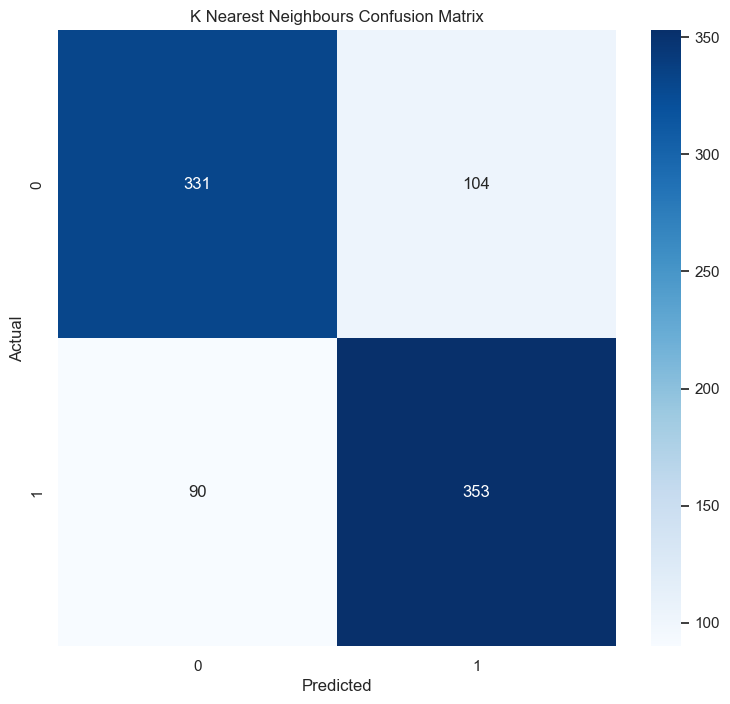

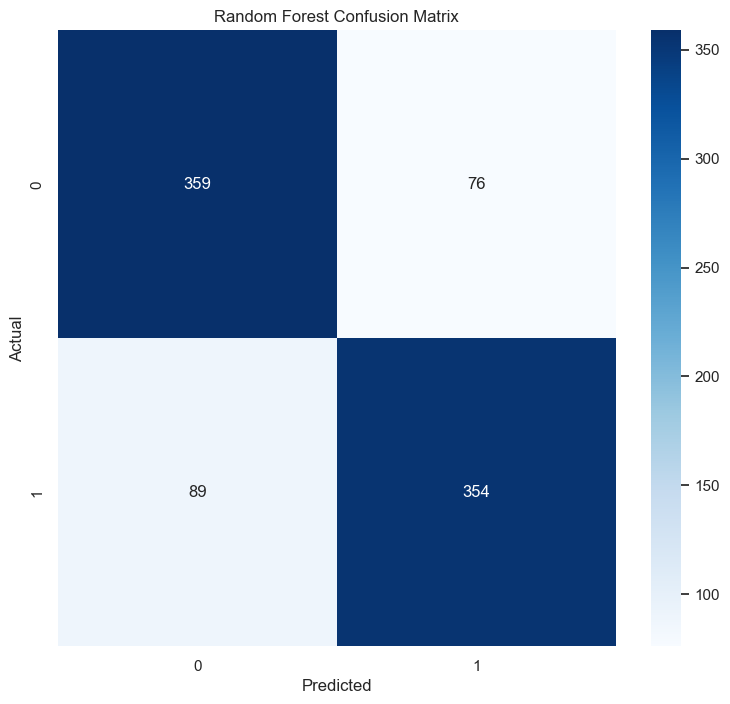

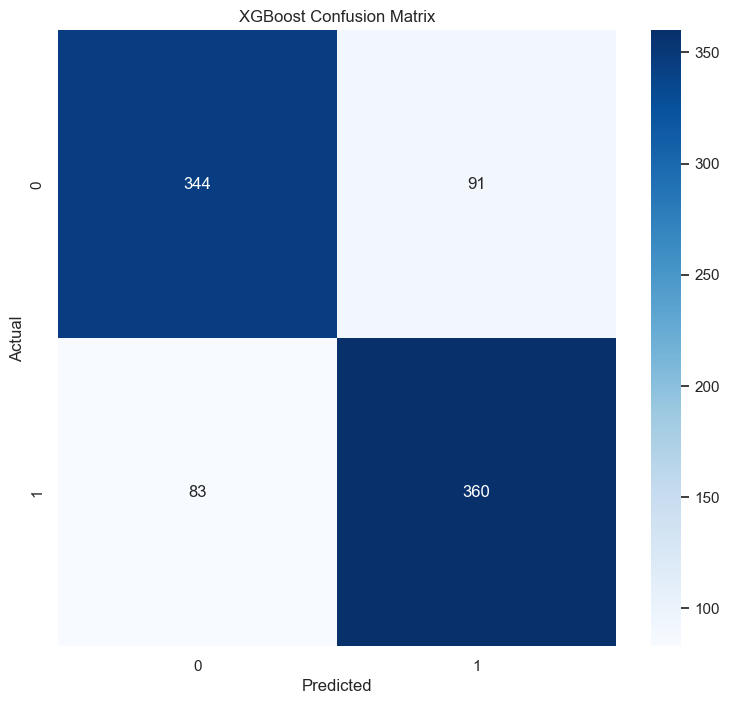

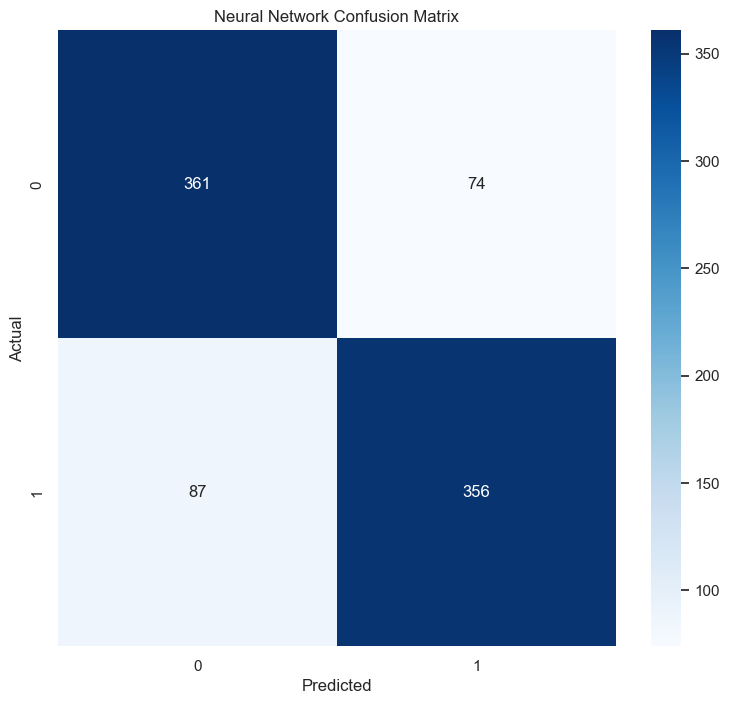

--------------
Accuracy Results
--------------
Null Hypothesis -> 0.504551948051948
KNN             -> 0.7790974025974027
Random Forest   -> 0.8121038961038961
XGBoost         -> 0.8018376623376623
Neural Networks -> 0.8166883116883117
--------------

--------------
Recall Results
--------------
Null Hypothesis -> 1.0
KNN             -> 0.7969356486210419
Random Forest   -> 0.799208375893769
XGBoost         -> 0.8128192032686414
Neural Networks -> 0.8038049029622064
--------------

--------------
AUC Results
--------------
Null Hypothesis -> 0.5
KNN             -> 0.7789275944254636
Random Forest   -> 0.8122478661078041
XGBoost         -> 0.8018119004848956
Neural Networks -> 0.8168449802167354
--------------


In [63]:
# Analyse the results
# Accuracy
knn_accuracy_av = sum(knn_accuracy)/len(knn_accuracy)
rf_accuracy_av = sum(rf_accuracy)/len(rf_accuracy)
xg_accuracy_av = sum(xg_accuracy)/len(xg_accuracy)
nn_accuracy_av = sum(nn_accuracy)/len(nn_accuracy)
# Recall
knn_recall_av = sum(knn_recall)/len(knn_recall)
rf_recall_av = sum(rf_recall)/len(rf_recall)
xg_recall_av = sum(xg_recall)/len(xg_recall)
nn_recall_av = sum(nn_recall)/len(nn_recall)
# AUC 
knn_auc_av = sum(knn_auc)/len(knn_auc)
rf_auc_av = sum(rf_auc)/len(rf_auc)
xg_auc_av = sum(xg_auc)/len(xg_auc)
nn_auc_av = sum(nn_auc)/len(nn_auc)

# Display results
# Confusion Matrix
plot_confusion_matrix(knn_conf_matrix, "K Nearest Neighbours Confusion Matrix")
plot_confusion_matrix(rf_conf_matrix, "Random Forest Confusion Matrix")
plot_confusion_matrix(xg_conf_matrix, "XGBoost Confusion Matrix")
plot_confusion_matrix(nn_conf_matrix, "Neural Network Confusion Matrix")

print("--------------")
print("Accuracy Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_accuracy))
print("KNN             -> " + str(knn_accuracy_av))
print("Random Forest   -> " + str(rf_accuracy_av))
print("XGBoost         -> " + str(xg_accuracy_av))
print("Neural Networks -> " + str(nn_accuracy_av))
print("--------------")
print("")
print("--------------")
print("Recall Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_recall))
print("KNN             -> " + str(knn_recall_av))
print("Random Forest   -> " + str(rf_recall_av))
print("XGBoost         -> " + str(xg_recall_av))
print("Neural Networks -> " + str(nn_recall_av))
print("--------------")
print("")
print("--------------")
print("AUC Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_AUC))
print("KNN             -> " + str(knn_auc_av))
print("Random Forest   -> " + str(rf_auc_av))
print("XGBoost         -> " + str(xg_auc_av))
print("Neural Networks -> " + str(nn_auc_av))
print("--------------")

# PENDING - Fine tune parameters